<a href="https://colab.research.google.com/github/msmccann10/Portfolio/blob/main/Sales-predictions/Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sales Prediction** 
- **Author:** Michael McCann
- **Last Updated:** 20 MAR 2022

In [ ]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn import set_config
set_config(display='diagram')

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.facecolor' : 'white', 
             'savefig.transparent' : 'False', 
             'savefig.facecolor' : 'white'})

In [ ]:
# Load Data
url = 'https://raw.githubusercontent.com/msmccann10/Portfolio/main/Sales-predictions/data/sales_predictions.csv'
sales_raw = pd.read_csv(url)

The data used for this analysis comes from a [data hack challenge](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/) hosted by analyticsvidhya.com. The corresponding dataset can be found [here](https://drive.google.com/file/d/1syH81TVrbBsdymLT_jl2JIf6IjPXtSQw/view).

- **Item_Identifier**:	Unique product ID
- **Item_Weight	Weight**: of product
- **Item_Fat_Content**:	Whether the product is low fat or regular
- **Item_Visibility**:	The percentage of total display area of all products in a store allocated to the particular product
- **Item_Type**:	The category to which the product belongs
- **Item_MRP**:	Maximum Retail Price (list price) of the product
- **Outlet_Identifier**:	Unique store ID
- **Outlet_Establishment_Year**:	The year in which store was established
- **Outlet_Size**:	The size of the store in terms of ground area covered
- **Outlet_Location_Type**:	The type of area in which the store is located
- **Outlet_Type**:	Whether the outlet is a grocery store or some sort of supermarket
- **Item_Outlet_Sales**:	Sales of the product in the particular store. This is the target variable to be predicted.

In [ ]:
display(sales_raw.head())
print('\n')
sales_raw.info()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# **Data Cleaning**

In [ ]:
sales_clean = sales_raw.copy()

## Dataframe Shape and Structure

As evidenced by our df.head and df.info printed above we can see that our dataframe is made up of 12 columns and 8253 rows. The data types used in this dataframe is a mix of objects, ints, and floats. It is noteworthy that the Year column is and int vice a datetime type. 

## Duplicate Rows/Values Check 1

In [ ]:
## Check for duplicates
display(sales_clean.duplicated().sum())
print('\n')
sales_clean[sales_clean.duplicated()]

0

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


## Missing Values

In [ ]:
## Lets identify our missing values (NaN).
sales_clean.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
## NaN only appears in the Item_Weight and Outlet_Size columns. Lets look closer at those values in Item_Weight and Outlet_Size columns.
display(sales_clean[sales_clean['Item_Weight'].isna()])
print("\n")
sales_clean[sales_clean['Outlet_Size'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [ ]:
## Fixing the Item Weight NAs 
sales_clean['Item_Weight'] = sales_clean['Item_Weight'].fillna(sales_clean.groupby('Item_Identifier')['Item_Weight'].transform('mean'))

sales_clean = sales_clean.dropna(subset = ['Item_Weight'])
sales_clean.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
## Lets take a look at the NaN's in Outlet_Size to see if there is a rhyme or reason here... 
display(sales_clean['Outlet_Size'].value_counts())
print("\n")

display(sales_clean.groupby(['Outlet_Identifier'])['Outlet_Size'].value_counts(dropna = False))
print("\n")

sales_clean.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Outlet_Size'].value_counts(dropna = False)

Medium    2790
Small     2387
High       932
Name: Outlet_Size, dtype: int64

Outlet_Identifier  Outlet_Size
OUT010             NaN            555
OUT013             High           932
OUT017             NaN            926
OUT018             Medium         928
OUT019             Small          527
OUT027             Medium         932
OUT035             Small          930
OUT045             NaN            929
OUT046             Small          930
OUT049             Medium         930
Name: Outlet_Size, dtype: int64

Outlet_Location_Type  Outlet_Type        Outlet_Size
Tier 1                Grocery Store      Small           527
                      Supermarket Type1  Medium          930
                                         Small           930
Tier 2                Supermarket Type1  NaN            1855
                                         Small           930
Tier 3                Grocery Store      NaN             555
                      Supermarket Type1  High            932
                      Supermarket Type2  Medium          928
                      Supermarket Type3  Medium          932
Name: Outlet_Size, dtype: int64

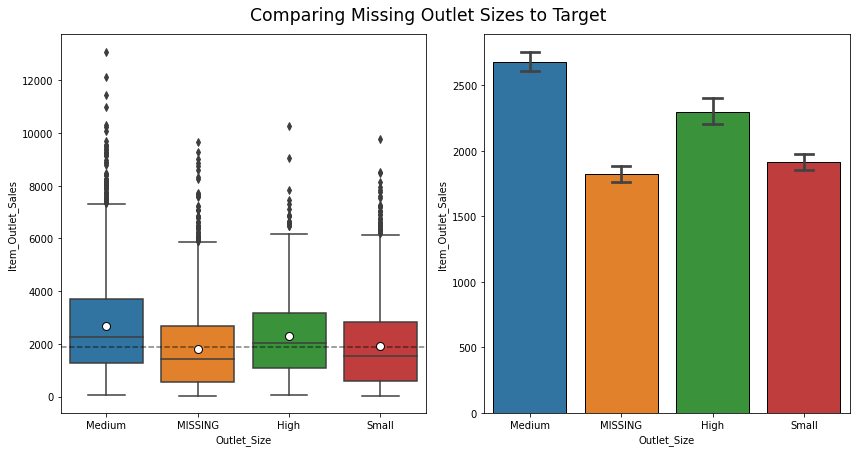

In [ ]:
## Compare the Mean/Medians of the Missing Data in the Outlet Size
fig, axes = plt.subplots(figsize = (12,6), ncols=2)
sns.boxplot(data=sales_clean.fillna('MISSING'), 
            x = 'Outlet_Size', 
            y = 'Item_Outlet_Sales', 
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"},
            ax=axes[0])
sns.barplot(data=sales_clean.fillna('MISSING'), 
            x = 'Outlet_Size', 
            y = 'Item_Outlet_Sales', 
            edgecolor = 'k',
            capsize = .2, 
            ax=axes[1])
axes[0].axhline(1875, color='k',ls="--", label= "label", alpha = .5)
fig.suptitle('Comparing Missing Outlet Sizes to Target', y = 1.04, size = 'xx-large')
fig.tight_layout();

<br>

It appears that there is no overlap between outlet identifiers and our missing outlet sizes meaning we cannot directly match those outlets based on other available data. Identfier OUT010, OUT017, and OUT045 are all NaN with no size to match against. <br><br>
On first glance it appears that  Location Type (Tier 1, 2, or 3) and Outlet Type (Grocery, Supermarket, etc) do not cleanly match up with size (Ex: Tier 3 Location has both High and Medium Sized Outlets; and Supermarket Type 1 Types are both small and medium).<br><br>
However, analysis of the medians and means demonstrated in the above visuals demonstrates that the mean, median, and distribution of the data are very similar leading us to believe that classifying the NaN's as Small would be the most prudent course of action.
<br>

In [ ]:
# Fill NaN in Outlet_Size with MISSING (see above for reasoning). 
sales_clean['Outlet_Size'] = sales_clean['Outlet_Size'].fillna('Small')

# Change High to Large for consistentcy
high_map = {'High': 'Large'}

sales_clean['Outlet_Size'] = sales_clean['Outlet_Size'].replace(high_map, regex = True)

In [ ]:
sales_clean['Outlet_Size'].value_counts()

Small     4797
Medium    2790
Large      932
Name: Outlet_Size, dtype: int64

In [ ]:
## Now that we have (theoretically) eliminated our mising values... lets check to see if they are all gone...
display(sales_clean.isna().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Inconsistent Data 

In [ ]:
## Isolate the object columns for evaluation...
data_types = sales_clean.dtypes
str_cols = data_types[data_types == 'object'].index
str_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [ ]:
## Print values of Object columns for examination... 
for col in str_cols:
    print(f' - {col}:')
    print(sales_clean[col].value_counts())
    print("\n")

 - Item_Identifier:
FDG33    10
FDW13    10
FDV60     9
FDU12     9
FDX20     9
         ..
DRF48     1
FDY43     1
FDC23     1
FDO33     1
FDT35     1
Name: Item_Identifier, Length: 1555, dtype: int64


 - Item_Fat_Content:
Low Fat    5088
Regular    2886
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


 - Item_Type:
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


 - Outlet_Identifier:
OUT013    932
OUT027    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    

<br>

Inconsistent categorizing in the Item_Fat_Content column: 
- Low Fat/LF/low fat
- reg/Regular

<br>

In [ ]:
## Fix the values in Item_Fat_Content using a replacement map and str.lower()...
repl_map = {'reg': 'regular', "LF": "low fat"}

sales_clean['Item_Fat_Content'] = sales_clean['Item_Fat_Content'].replace(repl_map, regex = True)
sales_clean['Item_Fat_Content'] = sales_clean['Item_Fat_Content'].str.lower()

## Check that it worked... 
print(sales_clean['Item_Fat_Content'].value_counts())

low fat    5516
regular    3003
Name: Item_Fat_Content, dtype: int64


## Duplicate Rows/Values Check 2
- Having fixed the missing values and inconsistent data lets see if any duplicate values popped up. 

In [ ]:
## Check for duplicates
display(sales_clean.duplicated().sum())
print('\n')
sales_clean[sales_clean.duplicated()]

0

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


# EDA and Visualizations

## Summary Statistics

In [ ]:
sales_eda = sales_clean.copy()

In [ ]:
sales_eda.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.00,8519.00,8519.00,8519.00,8519.00
mean,12.88,0.07,141.01,1997.84,2181.19
std,4.65,0.05,62.28,8.37,1706.51
min,4.56,0.00,31.29,1985.00,33.29
25%,8.78,0.03,93.84,1987.00,834.25
50%,12.65,0.05,143.05,1999.00,1794.33
75%,16.85,0.09,185.68,2004.00,3100.63
max,21.35,0.33,266.89,2009.00,13086.96


## Data Distribution (Historgrams)
The below histograms show the distribution of our data and allow for us to spot check for any anomalies.

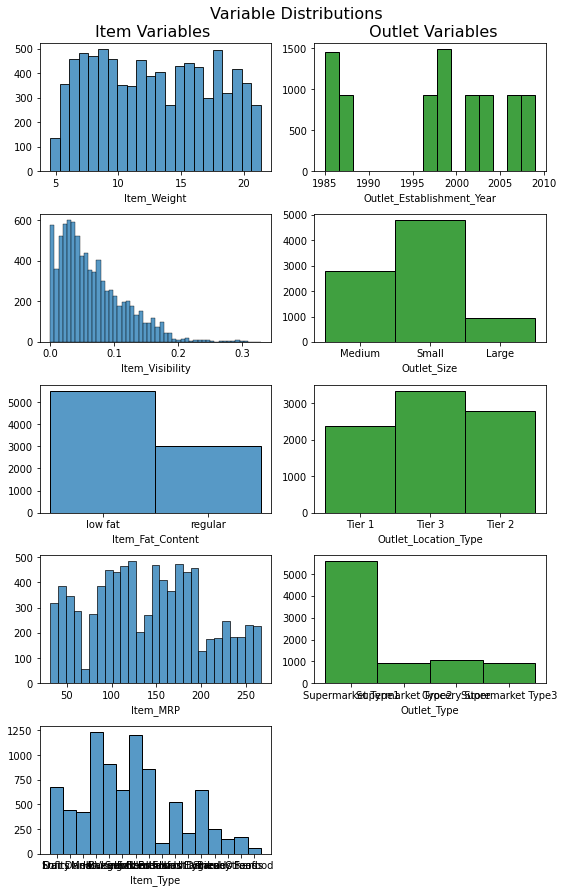

In [ ]:
## Plot histograms of main data columns for easy/initial analysis of data distribution. Usefull for EDA.
fig, axes = plt.subplots(nrows=5, ncols = 2, figsize= (8, 12))
sns.histplot(data=sales_eda,x='Item_Weight', ax = axes[0 ,0])
sns.histplot(data=sales_eda,x='Item_Visibility', ax = axes[1, 0])
sns.histplot(data=sales_eda,x='Item_Fat_Content', ax = axes[2, 0])
sns.histplot(data=sales_eda,x='Item_Type', ax = axes[4 ,0])
sns.histplot(data=sales_eda,x='Item_MRP', ax = axes[3, 0])
sns.histplot(data=sales_eda,x='Outlet_Establishment_Year', color = 'g', ax = axes[0, 1])
sns.histplot(data=sales_eda,x='Outlet_Size', color = 'g', ax = axes[1, 1])
sns.histplot(data=sales_eda,x='Outlet_Location_Type', color = 'g', ax = axes[2, 1])
sns.histplot(data=sales_eda,x='Outlet_Type', color = 'g', ax = axes[3, 1])
fig.suptitle('Variable Distributions\nItem Variables                               Outlet Variables', x = .52, y = 1.03, fontsize=16)
for i in range(5):
    axes[i,0].set_ylabel('')
for i in range(4):
    axes[i,1].set_ylabel('')
fig.delaxes(ax = axes[4,1])
plt.tight_layout();

**Interpretation:** Nothing major to interpret here. This is more of a quick reference for how the data is organized/laid out. A few things stand out:
- Item visibility is left skewed which makes sense given the premium put on visibiltiy in a store.
-Both Item Weight and Item MRP appear to be fairly evenly distributed.
-There is a large gap in Outlet Establishment from 1987 to 1997. 
-'Missing' Values in Outlet Size make up a large percentage of the data and may skew the findings. 
-Supermarket Type1 makes up a large percentage of the Outlet Type variables.

## Correlation Check (Heatmap)

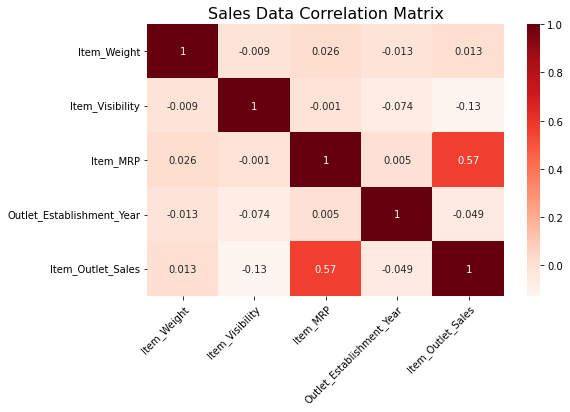

In [ ]:
## Establish correlation
corr = round(sales_eda.corr(), 3)

## Plot correlation matrix
fig, ax = plt.subplots(figsize= (8,5))
sns.heatmap(corr, cmap = 'Reds', annot = True, ax = ax)
plt.title('Sales Data Correlation Matrix', fontsize = 16)
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor');

**Interpretation:** The correlation matrix reveals no strong positive or negative correlations (above 0.8 or below -0.8). between the numerically measured data. 
- Item MRP and Sales had a nearly moderate correlation which would be expected since MRP is a measure of maximum retail price.
- I had expected to see a larger correlation between visibility and sales which we may interogate later in our EDA.

Obviously this does not measure correlation and/or relationships between sales and non-numeric variables such as fat content, store size, or store location.

## Location, Location, Location (Boxplots)
The below boxplots compare Item Sales against the three outlet variables measuring size and location (Outlet_Size, Outlet_Location_Type, and Outlet_Type).

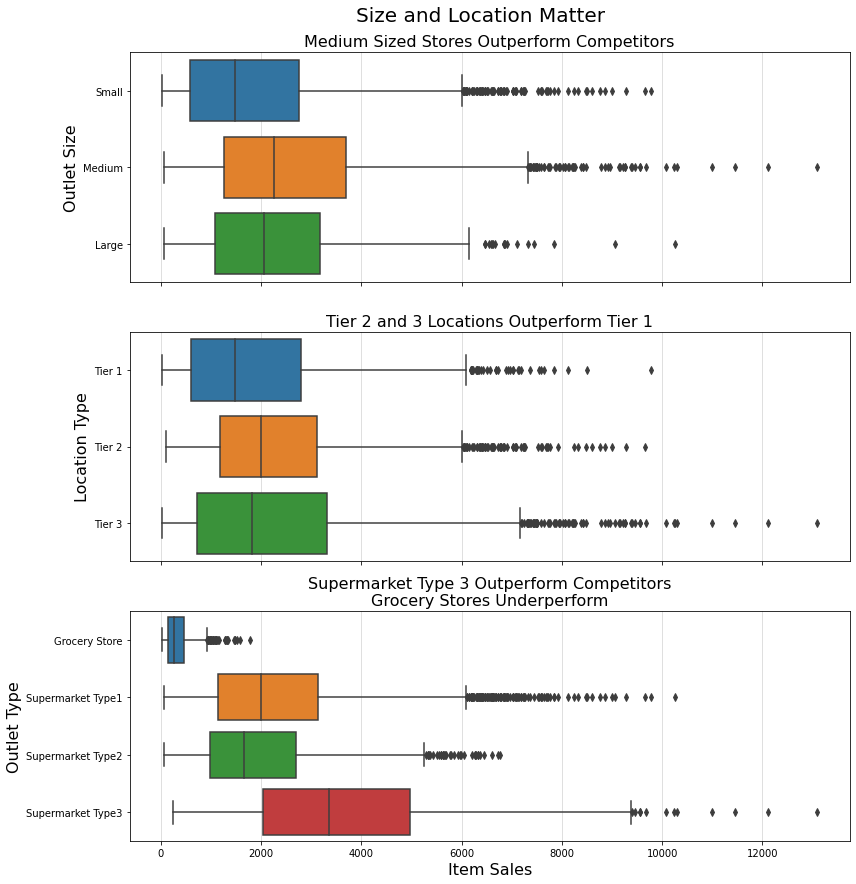

In [ ]:
## Create boxplots for Outlet Size, Location, and Type
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (12,12), sharex = True)
sns.boxplot(data = sales_eda, x = 'Item_Outlet_Sales', y = 'Outlet_Size', order = ("Small", "Medium", "Large"), ax = axes[0])
sns.boxplot(data = sales_eda, x = 'Item_Outlet_Sales', y = 'Outlet_Location_Type', order = ("Tier 1", "Tier 2", "Tier 3"), ax = axes[1])
sns.boxplot(data = sales_eda, x = 'Item_Outlet_Sales', y = 'Outlet_Type', order = ("Grocery Store", "Supermarket Type1", "Supermarket Type2", "Supermarket Type3"), ax = axes[2])
fig.suptitle('Size and Location Matter', fontsize=20, y = 1.02, x = .56)
axes[0].set_title('Medium Sized Stores Outperform Competitors', fontsize = 16)
axes[0].set_xlabel('');
axes[0].set_ylabel('Outlet Size', fontsize = 16)
axes[1].set_title('Tier 2 and 3 Locations Outperform Tier 1', fontsize = 16)
axes[1].set_xlabel('')
axes[1].set_ylabel('Location Type', fontsize = 16)
axes[2].set_title('Supermarket Type 3 Outperform Competitors\nGrocery Stores Underperform', fontsize = 16)
axes[2].set_xlabel('Item Sales', fontsize = 16)
axes[2].set_ylabel('Outlet Type', fontsize = 16)
[ax.grid(axis = 'x', alpha = .5) for ax in axes]
[ax.set_axisbelow(True) for ax in axes]
plt.tight_layout();

**Interpretation:** The above boxplots indicate that:
- *Size:* Medium and Large Outlets appear to outperform Small Outlets
- *Location:* Tier 3 locations have the highest possible outcomes (outliers) whereas Tier 2 locations have the highest median sales and a similar ceiling to Tier 1 locations.
- *Type:* Grocery Stores appear have the lowest amount of sales by a wide margin. Type 3 Supermarkets have a significantly higher Q1, above the Q3 of Type 1 and 2 Supermarkets. This means that despite having similar upper end outcomes they have fewer low outcomes giving them a higher floor.

It is important to note that these variables are not well defined in the dataset and we are not able to determine what differentiates these categories. Additionally, Outlet Size has a large number of "missing" values which we were unable to impute and therefore may skew the data in this particular boxplot.


## Item MRP (lmplot)

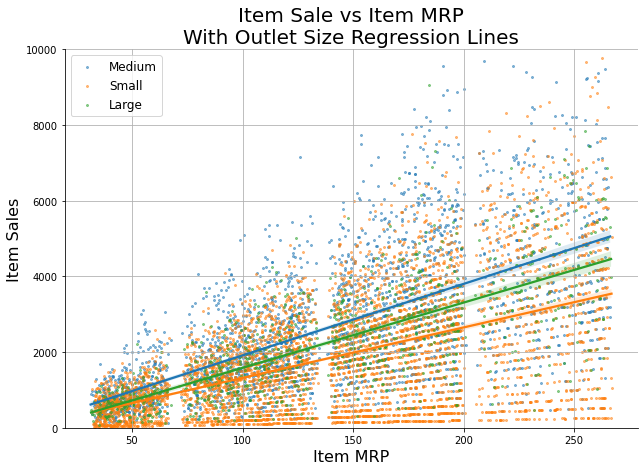

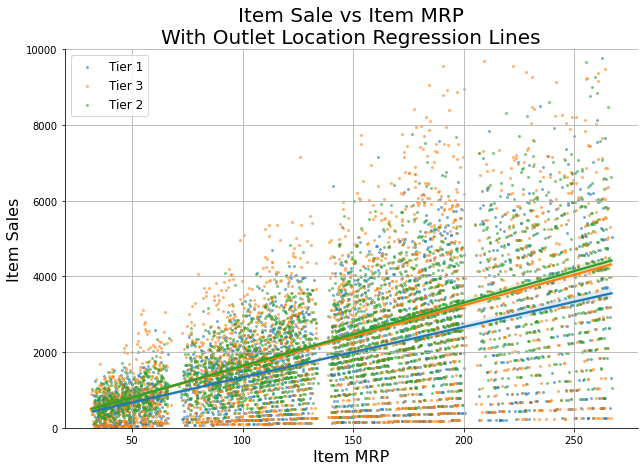

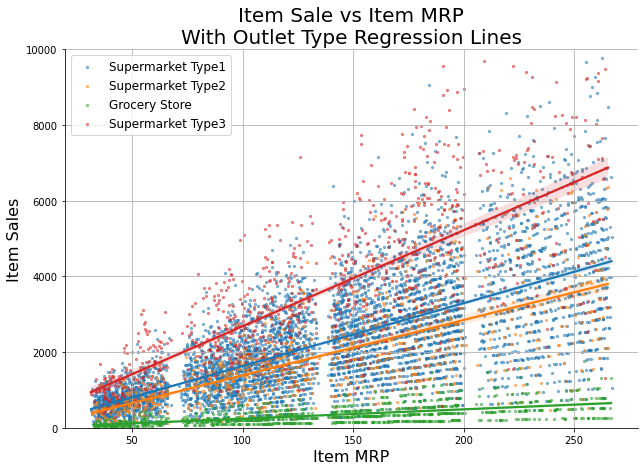

In [ ]:
## Create Scatter/Regression plots for MPR v Sales
sns.lmplot(data = sales_eda, x = 'Item_MRP', y = 'Item_Outlet_Sales', hue = 'Outlet_Size', 
           legend=False, height=6, aspect=1.5,
           scatter_kws={'s':4, 'alpha': .5},)
plt.ylim(0,10000)
plt.legend(loc = 2, fontsize = 'large')
plt.grid()
plt.title('Item Sale vs Item MRP\nWith Outlet Size Regression Lines', fontsize = 20)
plt.xlabel('Item MRP', fontsize=16)
plt.ylabel('Item Sales', fontsize=16);

sns.lmplot(data = sales_eda, x = 'Item_MRP', y = 'Item_Outlet_Sales', hue = 'Outlet_Location_Type', 
           legend=False, height=6, aspect=1.5,
           scatter_kws={'s':4, 'alpha': .5})
plt.grid()
plt.ylim(0,10000)
plt.legend(loc = 2, fontsize = 'large')
plt.title('Item Sale vs Item MRP\nWith Outlet Location Regression Lines', fontsize = 20)
plt.xlabel('Item MRP', fontsize=16)
plt.ylabel('Item Sales', fontsize=16);

sns.lmplot(data = sales_eda, x = 'Item_MRP', y = 'Item_Outlet_Sales', hue = 'Outlet_Type', 
           legend=False, height=6, aspect=1.5,
           scatter_kws={'s':5, 'alpha': .5})
plt.grid()
plt.ylim(0,10000)
plt.legend(loc = 2, fontsize = 'large')
plt.title('Item Sale vs Item MRP\nWith Outlet Type Regression Lines', fontsize = 20)
plt.xlabel('Item MRP', fontsize=16)
plt.ylabel('Item Sales', fontsize=16);

**Interpretation:**

## Decreasing Return of Item Visibility (Scatterplot)




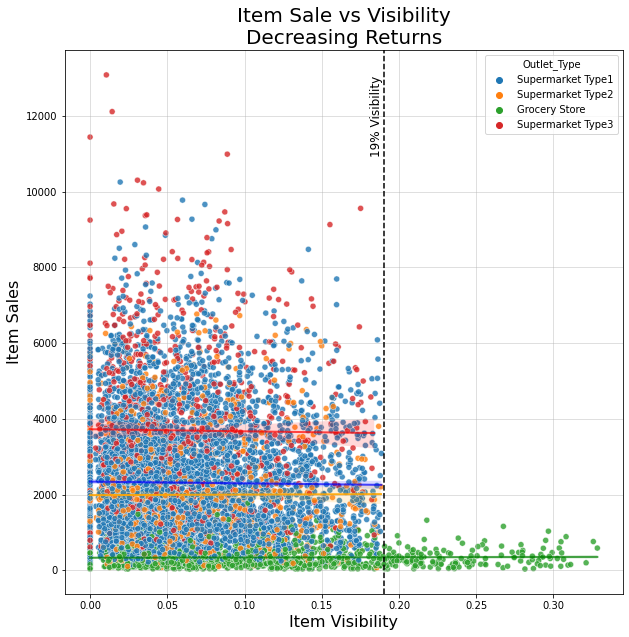

In [ ]:
## Create Scatter/Regression plots for sales v visibility
plt.figure(figsize = (10,10))
sns.scatterplot(data = sales_eda, x = 'Item_Visibility', y = 'Item_Outlet_Sales', hue = "Outlet_Type", alpha = .8)
sns.regplot(data=sales_eda[sales_eda['Outlet_Type'] == 'Grocery Store'], x = 'Item_Visibility', y = 'Item_Outlet_Sales', 
            scatter_kws={'s':0}, 
            line_kws={'color': "green", 'lw' : 2, 'alpha' : .7})
sns.regplot(data=sales_eda[sales_eda['Outlet_Type'] == 'Supermarket Type1'], x = 'Item_Visibility', y = 'Item_Outlet_Sales', 
            scatter_kws={'s':0}, 
            line_kws={'color': "blue", 'lw' : 2, 'alpha' : .7})
sns.regplot(data=sales_eda[sales_eda['Outlet_Type'] == 'Supermarket Type2'], x = 'Item_Visibility', y = 'Item_Outlet_Sales', 
            scatter_kws={'s':0}, 
            line_kws={'color': "orange", 'lw' : 2, 'alpha' : .9})
sns.regplot(data=sales_eda[sales_eda['Outlet_Type'] == 'Supermarket Type3'], x = 'Item_Visibility', y = 'Item_Outlet_Sales', 
            scatter_kws={'s':0}, 
            line_kws={'color': "red", 'lw' : 2, 'alpha' : .7})
plt.axvline(.19, color='k',ls="--", label= "label")
plt.title('Item Sale vs Visibility\nDecreasing Returns', fontsize = 20)
plt.xlabel('Item Visibility', fontsize=16)
plt.ylabel('Item Sales', fontsize=16)
plt.annotate('19% Visibility', (.181,11000), rotation = 'vertical', size = 12)
plt.grid(alpha = .5);

**Interpretation:**

## Item Categories Ordered by Median and Mean MRP  (boxplot)
Which Item Categories have the highest MRP

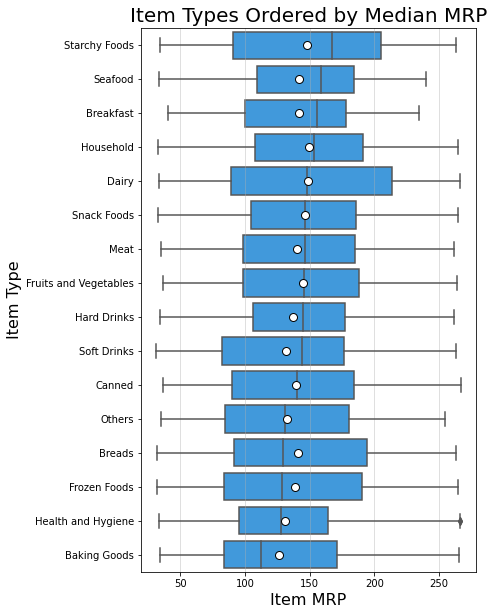

In [ ]:
## Boxplots showing order of Median Sales for MRP
IT_index = list(sales_eda.groupby('Item_Type')['Item_MRP'].median().sort_values(ascending = False).index)

plt.figure(figsize = (6,10))
sns.boxplot(data = sales_eda, y = 'Item_Type', x = 'Item_MRP', 
            color = '#279df5cc', 
            order = IT_index,            
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"},)
plt.grid(axis = 'x', alpha = .5)
plt.title('Item Types Ordered by Median MRP', fontsize = 20)
plt.xlabel('Item MRP', fontsize=16)
plt.ylabel('Item Type', fontsize=16);


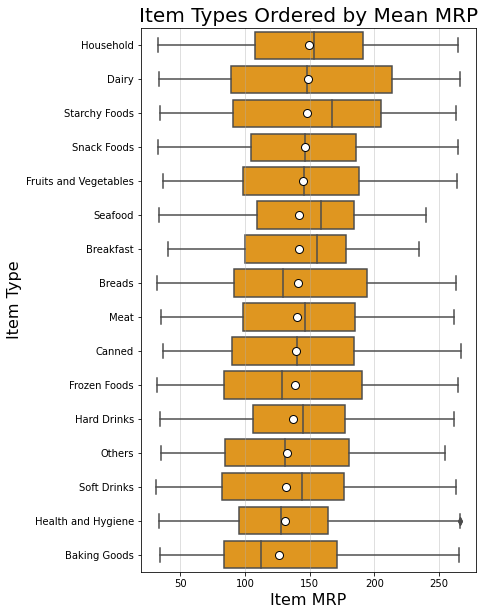

In [ ]:
## Boxplots showing order of Mean Sales for MRP
IT_index = list(sales_eda.groupby('Item_Type')['Item_MRP'].mean().sort_values(ascending = False).index)

plt.figure(figsize = (6,10))
sns.boxplot(data = sales_eda, y = 'Item_Type', x = 'Item_MRP', 
            color = '#ff9d00cc', 
            order = IT_index,            
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"},)
plt.grid(axis = 'x', alpha = .5)
plt.title('Item Types Ordered by Mean MRP', fontsize = 20)
plt.xlabel('Item MRP', fontsize=16)
plt.ylabel('Item Type', fontsize=16);

# Machine Learning

## Machine Learning Preprocessing

In [ ]:
## Load in fresh copy of dataframe for ML preprocessing
sales_ml = sales_raw.copy()

In [ ]:
## Apply Data Cleaning that will not negatively impact ML Preprocessing

# Clean Inconsistent Data (fat content for OHE)
repl_map = {'reg': 'regular', "LF": "low fat"}

sales_ml['Item_Fat_Content'] = sales_ml['Item_Fat_Content'].replace(repl_map, regex = True)
sales_ml['Item_Fat_Content'] = sales_ml['Item_Fat_Content'].str.lower()

# Clean Missing Values in Ordinal Features (Outlet Size)
sales_ml['Outlet_Size'] = sales_ml['Outlet_Size'].fillna('Small')

### Identify Features

In [ ]:
sales_ml.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,low fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,low fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,low fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
## Feature Engineering: code years as new/old.
year_dict = {}

for year in list(sales_ml['Outlet_Establishment_Year'].unique()):
    if year > 2000:
        year_dict.update({year: 'new'})
    else:
        year_dict.update({year: 'old'})

year_dict

sales_ml['Outlet_Establishment_Year'] = sales_ml['Outlet_Establishment_Year'].replace(year_dict)

In [ ]:
# sales_ml['Outlet_Establishment_Year'] = sales_ml['Outlet_Establishment_Year'].astype(str)
# sales_ml.info()

- **Item_Identifier**:	Drop as a unique value
- **Item_Weight	Weight**: Numeric
- **Item_Fat_Content**:	Nominal
- **Item_Visibility**:	Numeric
- **Item_Type**: Nominal
- **Item_MRP**:	Numeric
- **Outlet_Identifier**: Drop as a unique value
- **Outlet_Establishment_Year**: Nominal - Needs to be converted from int64.
- **Outlet_Size**: Ordinal
- **Outlet_Location_Type**:	Nominal
- **Outlet_Type**:	Nominal
<br><br>
- **Item_Outlet_Sales**:	Target

### Ordinal Encoding
- Ordinal Values: Outlet_Size

In [ ]:
sales_ml['Outlet_Size'].value_counts(dropna=False)

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [ ]:
## Ordinally encode using the size_dictionary
size_dictionary = {'Small': 0, 'Medium': 1, 'High':2}
sales_ml['Outlet_Size'] = sales_ml['Outlet_Size'].replace(size_dictionary)

sales_ml['Outlet_Size'].value_counts(dropna=False)

0    4798
1    2793
2     932
Name: Outlet_Size, dtype: int64

### Set Target and Feature Matrix
- Target = Item_Outlet_Sales
- Feature Matrix = All other features minus Item_Identifier and Outlet_Identifier

In [ ]:
## Set X and y
X = sales_ml.drop(columns = ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']) #, 'Outlet_Establishment_Year'])
y = sales_ml['Item_Outlet_Sales']

### Train Test Split

In [ ]:
## Run Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47)

### Create Pipeline

In [ ]:
## Create Column Selectors
cat_sel = make_column_selector(dtype_include = 'object')
num_sel = make_column_selector(dtype_include = 'number')

In [ ]:
## Create Pipeline
num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

In [ ]:
## Instantiate preprocessor
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (OneHotEncoder(handle_unknown='ignore', sparse = False), cat_sel),
                                       remainder = 'passthrough')

## Machine Learning Models

### Create Model Evaluator Function

In [ ]:
## Create Function
from numpy.ma.core import sqrt
def model_eval(train_true, test_true, train_pred, test_pred):
    #rsme_train = np.sqrt(mean_squared_error(train_true, train_pred)) 
    rsme_test = np.sqrt(mean_squared_error(test_true, test_pred))
    r2_train = r2_score(train_true, train_pred)
    r2_test = r2_score(test_true, test_pred)

    print(f'RSME: {rsme_test:.3f}\nR2 Train Score: {r2_train:.3f}\nR2 Test Score: {r2_test:.3f}')

In [ ]:
## Dummy Model for comparison
dummy = make_pipeline(preprocessor, DummyRegressor(strategy = 'mean'))
dummy.fit(X_train, y_train)

model_eval(y_train, y_test, dummy.predict(X_train), dummy.predict(X_test))

RSME: 1678.869
R2 Train Score: 0.000
R2 Test Score: -0.000


### Linear Regression

In [ ]:
## Instantiate and Fit
reg = make_pipeline(preprocessor, LinearRegression())
reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc32a168510>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc32a168310>)])),
                ('linearregression', LinearRegression())])

In [ ]:
## Evaluate the Model
model_eval(y_train, y_test, reg.predict(X_train), reg.predict(X_test))

RSME: 1135.226
R2 Train Score: 0.568
R2 Test Score: 0.543


### Decision Tree

In [ ]:
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
## Instantiate and Fit
dec_tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state = 42))
dec_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc32a168510>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc32a168310>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
## Evaluate the Model
model_eval(y_train, y_test, dec_tree.predict(X_train), dec_tree.predict(X_test))

RSME: 1547.810
R2 Train Score: 1.000
R2 Test Score: 0.150


In [ ]:
max_depth_range = list(range(2,10, 1))

r2 = []
for depth in max_depth_range:
    dec_tree = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth = depth,
                                                                 random_state = 42))
    dec_tree.fit(X_train, y_train)
    score = r2_score(y_test, dec_tree.predict(X_test))
    r2.append(score)

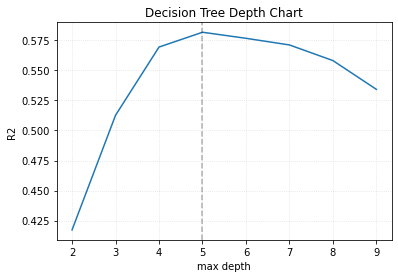

In [ ]:
plt.plot(max_depth_range, r2)
plt.axvline(5, color = 'k', ls = '--', alpha = .3)
plt.grid(alpha = .4, ls = ':')
plt.title('Decision Tree Depth Chart')
plt.xlabel('max depth')
plt.ylabel('R2');

In [ ]:
# Tuned Decision Tree
dt_tuned = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth = 5, random_state = 42))
dt_tuned.fit(X_train, y_train)

model_eval(y_train, y_test, dt_tuned.predict(X_train), dt_tuned.predict(X_test))

RSME: 1085.718
R2 Train Score: 0.609
R2 Test Score: 0.582


### Bagged Tree

In [ ]:
BaggingRegressor().get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
## Instantiate and Fit
bagreg = make_pipeline(preprocessor, BaggingRegressor(random_state=42))
bagreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc32a168510>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc32a168310>)])),
                ('baggingregressor', BaggingRegressor(random_state=42))])

In [ ]:
## Evaluate the Model
model_eval(y_train, y_test, bagreg.predict(X_train), bagreg.predict(X_test))

RSME: 1185.754
R2 Train Score: 0.917
R2 Test Score: 0.501


In [ ]:
estimator_range = list(range(120,141,2))

r2 = []
for est in estimator_range:
    bagreg = make_pipeline(preprocessor, BaggingRegressor(n_estimators = est,
                                                          random_state = 42))
    bagreg.fit(X_train, y_train)
    score = r2_score(y_test, bagreg.predict(X_test))
    r2.append(score)

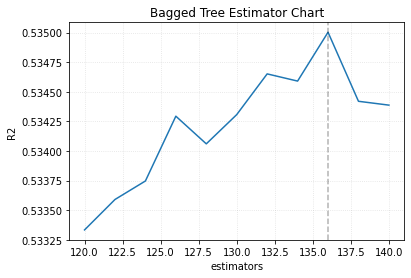

In [ ]:
plt.plot(estimator_range, r2)
plt.axvline(136, color = 'k', ls = '--', alpha = .3)
plt.grid(alpha = .4, ls = ':')
plt.title('Bagged Tree Estimator Chart')
plt.xlabel('estimators')
plt.ylabel('R2');

In [ ]:
# Tuned Bagged Tree
bagreg_tuned = make_pipeline(preprocessor, BaggingRegressor(n_estimators = 132,
                                                            random_state = 42))
bagreg_tuned.fit(X_train, y_train)

model_eval(y_train, y_test, bagreg_tuned.predict(X_train), bagreg_tuned.predict(X_test))

RSME: 1145.236
R2 Train Score: 0.938
R2 Test Score: 0.535


### Random Forest

In [ ]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
## Instantiate and Fit
rf = make_pipeline(preprocessor, RandomForestRegressor(random_state = 42))
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc32a168510>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc32a168310>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
## Evaluate the Model
model_eval(y_train, y_test, rf.predict(X_train), rf.predict(X_test))

RSME: 1148.524
R2 Train Score: 0.937
R2 Test Score: 0.532


In [ ]:
max_depth_range = list(range(4,11))

r2 = []
for depth in max_depth_range:
    rf = make_pipeline(preprocessor, RandomForestRegressor(max_depth = depth,
                                                           random_state = 42))
    rf.fit(X_train, y_train)
    score = r2_score(y_test, rf.predict(X_test))
    r2.append(score)

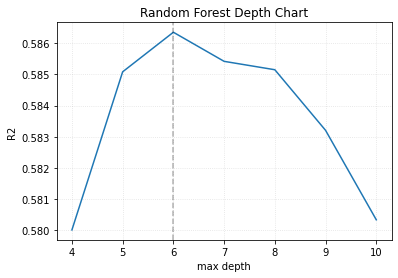

In [ ]:
plt.plot(max_depth_range, r2)
plt.axvline(6, color = 'k', ls = '--', alpha = .3)
plt.grid(alpha = .4, ls = ':')
plt.title('Random Forest Depth Chart')
plt.xlabel('max depth')
plt.ylabel('R2');

In [ ]:
estimator_range = list(range(270, 300,2))

r2 = []
for est in estimator_range:
    rf = make_pipeline(preprocessor, RandomForestRegressor(n_estimators = est,
                                                           max_depth = 6,
                                                           random_state = 42))
    rf.fit(X_train, y_train)
    score = r2_score(y_test, rf.predict(X_test))
    r2.append(score)

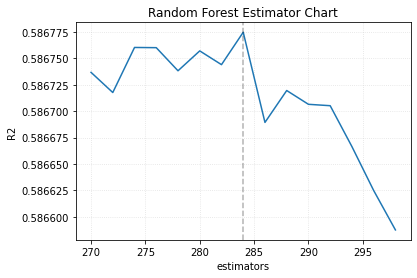

In [ ]:
plt.plot(estimator_range, r2)
plt.axvline(284, color = 'k', ls = '--', alpha = .3)
plt.grid(alpha = .4, ls = ':')
plt.title('Random Forest Estimator Chart')
plt.xlabel('estimators')
plt.ylabel('R2');

In [ ]:
sample_range = list(range(10, 21, 1))

r2 = []
for sample in sample_range:
    rf = make_pipeline(preprocessor, 
                       RandomForestRegressor(n_estimators = 284,
                                            max_depth = 6,
                                            random_state = 42,
                                            min_samples_split = sample))
    rf.fit(X_train, y_train)
    score = r2_score(y_test, rf.predict(X_test))
    r2.append(score)

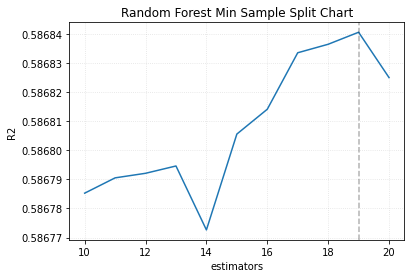

In [ ]:
plt.plot(sample_range, r2)
plt.axvline(19, color = 'k', ls = '--', alpha = .3)
plt.grid(alpha = .4, ls = ':')
plt.title('Random Forest Min Sample Split Chart')
plt.xlabel('estimators')
plt.ylabel('R2');

In [ ]:
sample_range = list(range(1, 21, 1))

r2 = []
for sample in sample_range:
    rf = make_pipeline(preprocessor, 
                       RandomForestRegressor(n_estimators = 284,
                                            max_depth = 6,
                                            random_state = 42,
                                            min_samples_split = 19,
                                            min_samples_leaf = sample))
    rf.fit(X_train, y_train)
    score = r2_score(y_test, rf.predict(X_test))
    r2.append(score)

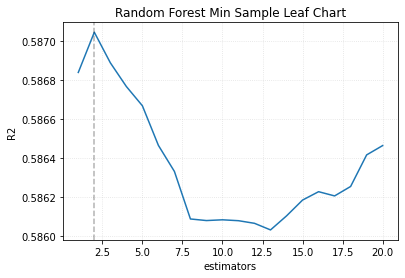

In [ ]:
plt.plot(sample_range, r2)
plt.axvline(2, color = 'k', ls = '--', alpha = .3)
plt.grid(alpha = .4, ls = ':')
plt.title('Random Forest Min Sample Leaf Chart')
plt.xlabel('estimators')
plt.ylabel('R2');

In [ ]:
rf_tuned = make_pipeline(preprocessor,
                         RandomForestRegressor(n_estimators = 284,
                                                max_depth = 6,
                                                random_state = 42,
                                                min_samples_split = 19,
                                                min_samples_leaf = 2))
rf_tuned.fit(X_train, y_train)

model_eval(y_train, y_test, rf_tuned.predict(X_train), rf_tuned.predict(X_test))

RSME: 1078.837
R2 Train Score: 0.628
R2 Test Score: 0.587


## Machine Learning Scores

In [ ]:
## Run Evaluator for Comparison across all models
print('BASELINE / DUMMY TEST')
model_eval(y_train, y_test, dummy.predict(X_train), dummy.predict(X_test))
print('\nLINEAR REGRESSION')
model_eval(y_train, y_test, reg.predict(X_train), reg.predict(X_test))
print('\nDECISION TREES')
model_eval(y_train, y_test, bagreg.predict(X_train), bagreg.predict(X_test))
print('\nBAGGED TREES')
model_eval(y_train, y_test, bagreg_tuned.predict(X_train), bagreg_tuned.predict(X_test))
print('\nRANDOM FOREST')
model_eval(y_train, y_test, rf.predict(X_train), rf.predict(X_test))

BASELINE / DUMMY TEST
RSME: 1678.869
R2 Train Score: 0.000
R2 Test Score: -0.000

LINEAR REGRESSION
RSME: 1135.226
R2 Train Score: 0.568
R2 Test Score: 0.543

DECISION TREES
RSME: 1145.560
R2 Train Score: 0.938
R2 Test Score: 0.534

BAGGED TREES
RSME: 1145.236
R2 Train Score: 0.938
R2 Test Score: 0.535

RANDOM FOREST
RSME: 1079.597
R2 Train Score: 0.623
R2 Test Score: 0.586


## Feature Importance

In [ ]:
## RF Feature Importance
cat_feat_names = rf_tuned.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out(cat_sel(X_train))

feature_names = num_sel(X_train) + list(cat_feat_names)

coefs = rf_tuned.named_steps['randomforestregressor'].feature_importances_

importance = pd.Series(coefs, index = feature_names)
importance.sort_values(ascending = False) * 100

Item_MRP                           54.359668
Outlet_Type_Grocery Store          31.998762
Outlet_Type_Supermarket Type3      11.429220
Item_Visibility                     0.839231
Item_Weight                         0.325092
Outlet_Type_Supermarket Type1       0.147482
Item_Type_Fruits and Vegetables     0.145792
Outlet_Type_Supermarket Type2       0.135961
Item_Type_Household                 0.072962
Item_Type_Seafood                   0.071741
Item_Type_Snack Foods               0.061439
Item_Type_Dairy                     0.056715
Item_Type_Baking Goods              0.047378
Item_Type_Hard Drinks               0.036451
Item_Type_Breakfast                 0.035914
Item_Type_Health and Hygiene        0.029724
Item_Type_Frozen Foods              0.029234
Item_Type_Soft Drinks               0.027825
Outlet_Location_Type_Tier 2         0.019147
Item_Fat_Content_regular            0.017166
Item_Fat_Content_low fat            0.015882
Item_Type_Meat                      0.015342
Item_Type_

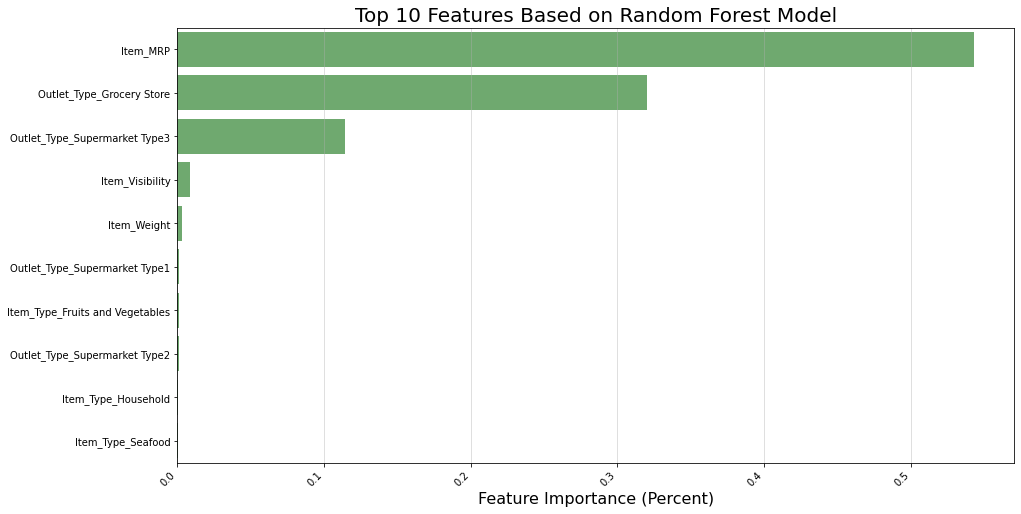

In [ ]:
## RF Feature Importance - Plot
importance10 = importance.sort_values(ascending = False).head(10)
plt.figure(figsize = (15, 8))
sns.barplot(y = importance10.index, x = importance10.values, color = 'green', alpha = .6)
plt.xticks(rotation = 45, ha = 'right')
plt.grid(axis = 'x', alpha = .5)
plt.title('Top 10 Features Based on Random Forest Model', fontsize = 20)
plt.xlabel('Feature Importance (Percent)', fontsize=16)
plt.ylabel('', fontsize=16);

In [ ]:
## Linear Regression Feature Importance (Coefficients)
reg_import = pd.Series(reg[-1].coef_, index = feature_names)
reg_import = reg_import.sort_values(ascending = False)
reg_import

Outlet_Type_Supermarket Type3      1618.512378
Item_MRP                            975.109562
Item_Type_Seafood                   342.432765
Outlet_Type_Supermarket Type1       192.420436
Item_Type_Breakfast                  94.245813
Outlet_Location_Type_Tier 2          52.191292
Outlet_Size                          28.811827
Item_Fat_Content_regular             27.196159
Item_Type_Hard Drinks                18.918036
Item_Type_Canned                     18.237715
Outlet_Establishment_Year_old        14.054520
Item_Type_Fruits and Vegetables       4.333786
Item_Type_Breads                      1.273618
Outlet_Location_Type_Tier 1          -0.119344
Item_Type_Dairy                      -0.260504
Item_Weight                          -5.513760
Item_Visibility                      -8.928333
Outlet_Establishment_Year_new       -14.054520
Item_Type_Others                    -15.274127
Item_Type_Meat                      -26.245925
Item_Fat_Content_low fat            -27.196159
Item_Type_Sna

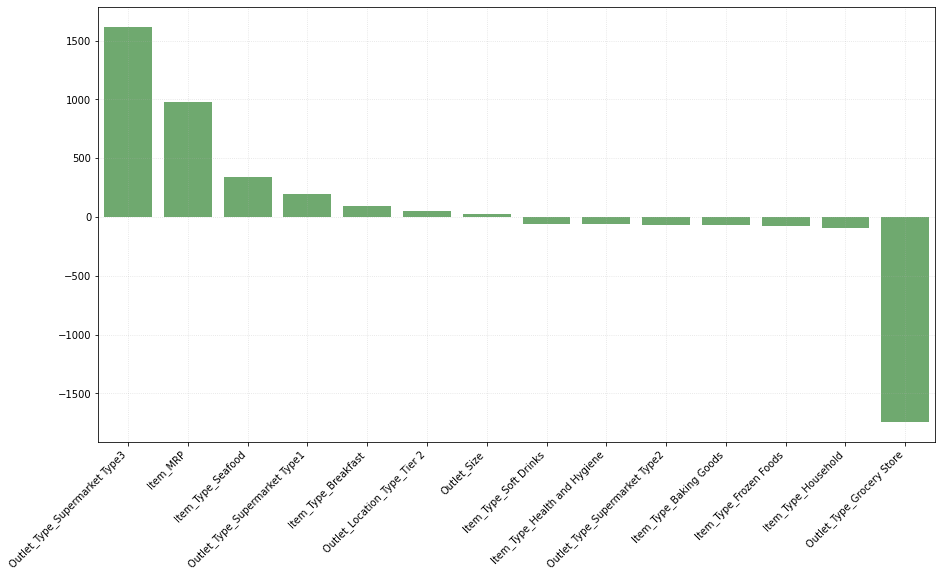

In [ ]:
## Linear Regression Feature Importance (Coefficients) - Plot
reg_bot = reg_import.sort_values(ascending=True).head(7)
reg_top = reg_import.sort_values(ascending=False).head(7)
reg_plot = pd.concat([reg_bot, reg_top]).sort_values(ascending = False)

plt.figure(figsize = (15, 8))
sns.barplot(reg_plot.index, reg_plot.values, color = 'green', alpha = .6)
plt.xticks(rotation = 45, ha = 'right')
plt.grid(ls = ':', alpha = .4);
